In [85]:
!pip install --upgrade pip
!pip install datasets accelerate transformers tqdm torch torchvision torchaudio requests "urllib3<2" scikit-learn matplotlib
!pip install -U accelerate
!pip install -U transformers

Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no
Looking in indexes: https://pypi.org/simple, https://pypi.idi.ntnu.no


In [86]:
from transformers import ViTFeatureExtractor
from transformers import TrainingArguments
from transformers import ViTForImageClassification, Trainer, TrainingArguments
import torch
import numpy as np
from datasets import load_dataset



In [87]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
x = torch.ones(1).to(device)
print(x)

tensor([1.], device='cuda:0')


In [88]:
def load_data():
    d_types = ['train'] # 60k images
    datasets = []
    for d in d_types:
        datasets.append(load_dataset(
            'mnist',
            split=d,
        ))
    return datasets

# 94% for validation, 1% for test and 5% for training
dataset = load_data()[0].map(lambda x: {'image': torch.tensor(np.repeat(np.array(x['image'])[:, :, np.newaxis], 3, axis=2)), 'label': x['label']})



Map:   1%|          | 470/60000 [00:00<00:12, 4652.10 examples/s]/home/tommydl/TDT05-Project-23/venv/lib/python3.10/site-packages/datasets/features/image.py:332: UserWarning: Downcasting array dtype int64 to uint8 to be compatible with 'Pillow'
  warnings.warn(f"Downcasting array dtype {dtype} to {dest_dtype} to be compatible with 'Pillow'")
Map: 100%|██████████| 60000/60000 [07:26<00:00, 134.39 examples/s]


In [99]:
split = dataset.train_test_split(test_size=0.94)
temp_split = split['train'].train_test_split(test_size=1/6)
dataset_train = temp_split['train']
dataset_test = temp_split['test']
dataset_valid = split['test']
dataset_train, dataset_test, dataset_valid

(Dataset({
     features: ['image', 'label'],
     num_rows: 3000
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 600
 }),
 Dataset({
     features: ['image', 'label'],
     num_rows: 56400
 }))

In [100]:
# check how many labels/number of classes
num_classes = len(set(dataset_train['label']))
labels = dataset_train.features['label'].names
num_classes, labels

(10, ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9'])

In [101]:
dataset_train['image'][1].size

(28, 28)

In [110]:
# import feature extraction model
model_id = 'google/vit-base-patch16-224-in21k'

feature_extractor = ViTFeatureExtractor.from_pretrained(
    model_id
)
model = ViTForImageClassification.from_pretrained(
    model_id,  # classification head
    num_labels=len(labels)
).to(device)

model.num_parameters()

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85806346

In [102]:
def preprocess(batch):
    # take a list of PIL images and turn them to pixel values
    inputs = feature_extractor(
        batch['image'],
        return_tensors='pt'
    )
    # include the labels
    inputs['labels'] = batch['label']
    return inputs

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['labels'] for x in batch])
    }

# transform the training dataset
prepared_train = dataset_train.with_transform(preprocess)
# ... and the testing dataset
prepared_test = dataset_test.with_transform(preprocess)
# ... and the validation dataset
prepared_valid = dataset_valid.with_transform(preprocess)



In [103]:
import numpy as np
from datasets import load_metric

# accuracy metric
metric = load_metric("accuracy")
def compute_metrics(p):
    return metric.compute(
        predictions=np.argmax(p.predictions, axis=1),
        references=p.label_ids
    )


In [112]:
eval_save_step = 100

# training the model
training_args = TrainingArguments(
  output_dir="./vit_model",
  per_device_train_batch_size=32,
  evaluation_strategy="steps",
  num_train_epochs=5,
  save_steps=eval_save_step,
  eval_steps=eval_save_step,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  optim='adamw_torch',
  remove_unused_columns=False,
  push_to_hub=False,
  load_best_model_at_end=True,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    train_dataset=prepared_train,
    eval_dataset=prepared_test,
    tokenizer=feature_extractor,
)

train_results = trainer.train(resume_from_checkpoint=False)
# save tokenizer with the model
trainer.save_model()
trainer.log_metrics("train", train_results.metrics)
trainer.save_metrics("train", train_results.metrics)
# save the trainer state
trainer.save_state()

  2%|▏         | 10/470 [00:03<02:21,  3.25it/s]

{'loss': 2.0823, 'learning_rate': 0.00019574468085106384, 'epoch': 0.11}


  4%|▍         | 20/470 [00:06<02:22,  3.15it/s]

{'loss': 1.3311, 'learning_rate': 0.00019148936170212768, 'epoch': 0.21}


  6%|▋         | 30/470 [00:10<02:16,  3.22it/s]

{'loss': 0.7644, 'learning_rate': 0.0001872340425531915, 'epoch': 0.32}


  9%|▊         | 40/470 [00:12<02:01,  3.54it/s]

{'loss': 0.493, 'learning_rate': 0.00018297872340425532, 'epoch': 0.43}


 11%|█         | 50/470 [00:15<02:00,  3.48it/s]

{'loss': 0.3984, 'learning_rate': 0.00017872340425531915, 'epoch': 0.53}


 13%|█▎        | 60/470 [00:18<01:54,  3.57it/s]

{'loss': 0.3148, 'learning_rate': 0.00017446808510638298, 'epoch': 0.64}


 15%|█▍        | 70/470 [00:21<01:55,  3.48it/s]

{'loss': 0.2579, 'learning_rate': 0.00017021276595744682, 'epoch': 0.74}


 17%|█▋        | 80/470 [00:24<01:53,  3.45it/s]

{'loss': 0.1984, 'learning_rate': 0.00016595744680851065, 'epoch': 0.85}


 19%|█▉        | 90/470 [00:27<01:50,  3.43it/s]

{'loss': 0.1677, 'learning_rate': 0.00016170212765957446, 'epoch': 0.96}


 21%|██▏       | 100/470 [00:30<01:46,  3.47it/s]

{'loss': 0.1566, 'learning_rate': 0.00015744680851063832, 'epoch': 1.06}



 21%|██▏       | 100/470 [00:33<01:46,  3.47it/s]

{'eval_loss': 0.17012116312980652, 'eval_accuracy': 0.9766666666666667, 'eval_runtime': 3.3638, 'eval_samples_per_second': 178.371, 'eval_steps_per_second': 22.296, 'epoch': 1.06}


 23%|██▎       | 110/470 [00:38<02:20,  2.57it/s]

{'loss': 0.1605, 'learning_rate': 0.00015319148936170213, 'epoch': 1.17}


 26%|██▌       | 120/470 [00:41<01:55,  3.02it/s]

{'loss': 0.1046, 'learning_rate': 0.00014893617021276596, 'epoch': 1.28}


 28%|██▊       | 130/470 [00:45<01:47,  3.17it/s]

{'loss': 0.1483, 'learning_rate': 0.0001446808510638298, 'epoch': 1.38}


 30%|██▉       | 140/470 [00:48<01:44,  3.17it/s]

{'loss': 0.1723, 'learning_rate': 0.00014042553191489363, 'epoch': 1.49}


 32%|███▏      | 150/470 [00:51<01:34,  3.39it/s]

{'loss': 0.1265, 'learning_rate': 0.00013617021276595746, 'epoch': 1.6}


 34%|███▍      | 160/470 [00:54<01:30,  3.41it/s]

{'loss': 0.0971, 'learning_rate': 0.00013191489361702127, 'epoch': 1.7}


 36%|███▌      | 170/470 [00:57<01:27,  3.43it/s]

{'loss': 0.1056, 'learning_rate': 0.00012765957446808513, 'epoch': 1.81}


 38%|███▊      | 180/470 [01:00<01:23,  3.47it/s]

{'loss': 0.1073, 'learning_rate': 0.00012340425531914893, 'epoch': 1.91}


 40%|████      | 190/470 [01:03<01:22,  3.40it/s]

{'loss': 0.1069, 'learning_rate': 0.00011914893617021277, 'epoch': 2.02}


 43%|████▎     | 200/470 [01:05<01:18,  3.45it/s]

{'loss': 0.0738, 'learning_rate': 0.00011489361702127661, 'epoch': 2.13}



 43%|████▎     | 200/470 [01:09<01:18,  3.45it/s]

{'eval_loss': 0.14511671662330627, 'eval_accuracy': 0.9683333333333334, 'eval_runtime': 3.2586, 'eval_samples_per_second': 184.126, 'eval_steps_per_second': 23.016, 'epoch': 2.13}


 45%|████▍     | 210/470 [01:13<01:36,  2.70it/s]

{'loss': 0.0508, 'learning_rate': 0.00011063829787234043, 'epoch': 2.23}


 47%|████▋     | 220/470 [01:16<01:14,  3.37it/s]

{'loss': 0.074, 'learning_rate': 0.00010638297872340425, 'epoch': 2.34}


 49%|████▉     | 230/470 [01:19<01:14,  3.22it/s]

{'loss': 0.0572, 'learning_rate': 0.00010212765957446809, 'epoch': 2.45}


 51%|█████     | 240/470 [01:22<01:07,  3.41it/s]

{'loss': 0.0614, 'learning_rate': 9.787234042553192e-05, 'epoch': 2.55}


 53%|█████▎    | 250/470 [01:25<01:06,  3.32it/s]

{'loss': 0.0641, 'learning_rate': 9.361702127659576e-05, 'epoch': 2.66}


 55%|█████▌    | 260/470 [01:27<01:00,  3.46it/s]

{'loss': 0.0477, 'learning_rate': 8.936170212765958e-05, 'epoch': 2.77}


 57%|█████▋    | 270/470 [01:30<00:58,  3.40it/s]

{'loss': 0.0543, 'learning_rate': 8.510638297872341e-05, 'epoch': 2.87}


 60%|█████▉    | 280/470 [01:33<00:55,  3.44it/s]

{'loss': 0.0437, 'learning_rate': 8.085106382978723e-05, 'epoch': 2.98}


 62%|██████▏   | 290/470 [01:36<00:52,  3.45it/s]

{'loss': 0.0551, 'learning_rate': 7.659574468085106e-05, 'epoch': 3.09}


 64%|██████▍   | 300/470 [01:39<00:49,  3.44it/s]

{'loss': 0.0286, 'learning_rate': 7.23404255319149e-05, 'epoch': 3.19}



 64%|██████▍   | 300/470 [01:43<00:49,  3.44it/s]

{'eval_loss': 0.07216043025255203, 'eval_accuracy': 0.9883333333333333, 'eval_runtime': 3.7862, 'eval_samples_per_second': 158.47, 'eval_steps_per_second': 19.809, 'epoch': 3.19}


 66%|██████▌   | 310/470 [01:47<00:56,  2.83it/s]

{'loss': 0.0267, 'learning_rate': 6.808510638297873e-05, 'epoch': 3.3}


 68%|██████▊   | 320/470 [01:50<00:44,  3.39it/s]

{'loss': 0.0294, 'learning_rate': 6.382978723404256e-05, 'epoch': 3.4}


 70%|███████   | 330/470 [01:53<00:43,  3.19it/s]

{'loss': 0.0241, 'learning_rate': 5.9574468085106384e-05, 'epoch': 3.51}


 72%|███████▏  | 340/470 [01:56<00:38,  3.41it/s]

{'loss': 0.0241, 'learning_rate': 5.531914893617022e-05, 'epoch': 3.62}


 74%|███████▍  | 350/470 [01:59<00:35,  3.39it/s]

{'loss': 0.0277, 'learning_rate': 5.1063829787234044e-05, 'epoch': 3.72}


 77%|███████▋  | 360/470 [02:02<00:31,  3.48it/s]

{'loss': 0.0224, 'learning_rate': 4.680851063829788e-05, 'epoch': 3.83}


 79%|███████▊  | 370/470 [02:05<00:29,  3.40it/s]

{'loss': 0.028, 'learning_rate': 4.2553191489361704e-05, 'epoch': 3.94}


 81%|████████  | 380/470 [02:08<00:26,  3.42it/s]

{'loss': 0.0213, 'learning_rate': 3.829787234042553e-05, 'epoch': 4.04}


 83%|████████▎ | 390/470 [02:11<00:23,  3.36it/s]

{'loss': 0.0209, 'learning_rate': 3.4042553191489365e-05, 'epoch': 4.15}


 85%|████████▌ | 400/470 [02:14<00:22,  3.15it/s]

{'loss': 0.0204, 'learning_rate': 2.9787234042553192e-05, 'epoch': 4.26}



 85%|████████▌ | 400/470 [02:18<00:22,  3.15it/s]

{'eval_loss': 0.069559246301651, 'eval_accuracy': 0.9883333333333333, 'eval_runtime': 3.9994, 'eval_samples_per_second': 150.022, 'eval_steps_per_second': 18.753, 'epoch': 4.26}


 87%|████████▋ | 410/470 [02:22<00:20,  2.86it/s]

{'loss': 0.0202, 'learning_rate': 2.5531914893617022e-05, 'epoch': 4.36}


 89%|████████▉ | 420/470 [02:25<00:14,  3.41it/s]

{'loss': 0.0212, 'learning_rate': 2.1276595744680852e-05, 'epoch': 4.47}


 91%|█████████▏| 430/470 [02:28<00:11,  3.49it/s]

{'loss': 0.0199, 'learning_rate': 1.7021276595744682e-05, 'epoch': 4.57}


 94%|█████████▎| 440/470 [02:31<00:08,  3.42it/s]

{'loss': 0.0198, 'learning_rate': 1.2765957446808511e-05, 'epoch': 4.68}


 96%|█████████▌| 450/470 [02:33<00:05,  3.52it/s]

{'loss': 0.0191, 'learning_rate': 8.510638297872341e-06, 'epoch': 4.79}


 98%|█████████▊| 460/470 [02:36<00:02,  3.51it/s]

{'loss': 0.0195, 'learning_rate': 4.255319148936171e-06, 'epoch': 4.89}


100%|██████████| 470/470 [02:39<00:00,  2.94it/s]


{'loss': 0.0348, 'learning_rate': 0.0, 'epoch': 5.0}
{'train_runtime': 159.7352, 'train_samples_per_second': 93.905, 'train_steps_per_second': 2.942, 'train_loss': 0.17668168240405144, 'epoch': 5.0}
***** train metrics *****
  epoch                    =        5.0
  train_loss               =     0.1767
  train_runtime            = 0:02:39.73
  train_samples_per_second =     93.905
  train_steps_per_second   =      2.942


In [114]:
# evaluate with validation
metrics = trainer.evaluate(prepared_valid)
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)


100%|██████████| 7050/7050 [05:26<00:00, 21.56it/s]

***** eval metrics *****
  epoch                   =        5.0
  eval_accuracy           =     0.9899
  eval_loss               =     0.0544
  eval_runtime            = 0:05:27.07
  eval_samples_per_second =    172.435
  eval_steps_per_second   =     21.554


Text(0.5, 1.0, 'ViT: Loss over train steps')

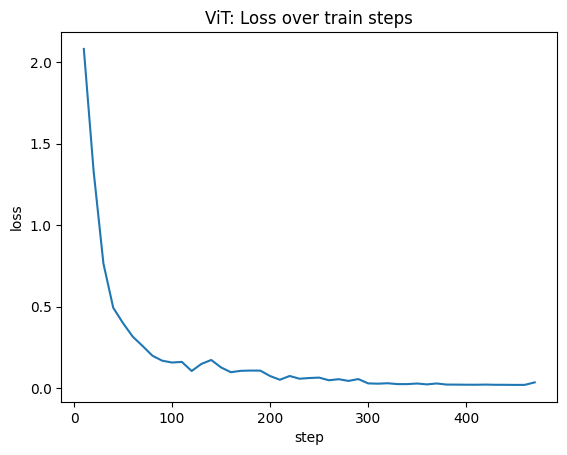

In [113]:
from matplotlib import pyplot as plt

x = [log['step'] for log in trainer.state.log_history if 'loss' in log]
y = [log['loss'] for log in trainer.state.log_history if 'loss' in log]


# y axis is loss
# x axis is step
plt.plot(x, y)
plt.xlabel('step')
plt.ylabel('loss')
plt.title('ViT: Loss over train steps')


In [119]:
# fine tuned model
# import our fine-tuned model
model_name_or_path = './vit_model'
model_finetuned = ViTForImageClassification.from_pretrained(model_name_or_path)
# import features
feature_extractor_finetuned = ViTFeatureExtractor.from_pretrained(model_name_or_path)

model_finetuned.num_parameters()


/home/tommydl/TDT05-Project-23/venv/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


85806346

In [120]:
def predict(image):
    inputs = feature_extractor_finetuned(image["image"], return_tensors="pt")
    # extract the actual label of the first image of the testing dataset
    actual_label = image["label"]

    with torch.no_grad():
        logits = model_finetuned(**inputs).logits

    predicted_label = logits.argmax(-1).item()
    return predicted_label


In [126]:
import random
index = random.randint(0, len(dataset_valid)-1)
print("Predicted "+str(predict(dataset_valid[index])))
dataset_valid[index]["image"]

Predicted 0
